In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import pandas as pd
sns.set_theme()
%load_ext autoreload
%autoreload 2


In [2]:
from nlpChess.utils.DatasetLoader import loadDataset

In [3]:
#Load the dataset
ds = loadDataset()
df = ds['validation'].to_pandas()
df.head()

Moves          Termination  \
0  [c2c4, c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g...            CHECKMATE   
1  [d2d4, g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d...            CHECKMATE   
2  [d2d4, c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a...            CHECKMATE   
3  [e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...  FIVEFOLD_REPETITION   
4  [g1f3, d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f...            CHECKMATE   

    Result                                             pieces  \
0      1-0  [p, p, p, n, b, p, n, p, p, b, k, p, n, p, b, ...   
1      1-0  [p, p, p, b, n, p, p, p, n, n, p, k, b, n, p, ...   
2      0-1  [p, p, p, p, n, n, n, p, p, p, p, p, b, n, k, ...   
3  1/2-1/2  [p, p, n, n, b, p, b, p, k, q, p, n, p, p, p, ...   
4      0-1  [n, p, p, n, b, p, k, b, p, p, b, p, p, b, p, ...   

                                            captures  \
0  [, , , , , , , , , , , p, p, , , , , , , , , ,...   
1  [, , , , , , , , , , , , , , , , , , n, n, , ,...   
2  [, , , , , , , , , , , , , , , p, p, p, p, , ,...   
3  [, , , , , , n, b, , , , , , p, , p, p, , , , ...   
4  [, , , , , , , , , , , , , , , , , , , , , , b...   

                                              checks  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                          next_moves  \
0  [c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g6, d2d...   
1  [g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d6, g1f...   
2  [c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a6, a2a...   
3  [e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c6, e1g...   
4  [d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f5, b2b...   

                                    termination_seqs  \
0  [CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...   
1  [CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...   
2  [CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...   
3  [FIVEFOLD_REPETITION, FIVEFOLD_REPETITION, FIV...   
4  [CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...   

                                         result_seqs  __index_level_0__  
0  [1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, ...              63137  
1  [1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, ...              75080  
2  [0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, ...              86128  
3  [1/2-1/2, 1/2-1/2, 1/2-1/2, 1/2-1/2, 1/2-1/2, ...              73626  
4  [0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, ...              44173

In [4]:
moves = df['Moves'][:10000]
moves.head()

0    [c2c4, c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g...
1    [d2d4, g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d...
2    [d2d4, c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a...
3    [e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...
4    [g1f3, d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f...
Name: Moves, dtype: object

In [5]:
from nlpChess.models import PretrainedModels
from nlpChess.models import Word2VecChess

In [6]:
modelNames = list(PretrainedModels.__members__.keys())
print(modelNames)
models = {name: PretrainedModels.__members__[name].loadModel() for name in modelNames}
modelLabels = {name: PretrainedModels.__members__[name].outcomesLabels for name in modelNames}

['NEXT_TOKEN', 'CAPTURES', 'CHECKS', 'PIECES', 'OUTCOMES']


In [7]:
#Get the word2vec embeddings
def getW2VEmbeddings(moves):
    return torch.Tensor(Word2VecChess.wv[moves])

movesEmbeddings = moves.apply(lambda x: getW2VEmbeddings(x))
movesEmbeddings.head()

0    [[tensor(0.1708), tensor(-0.3223), tensor(0.04...
1    [[tensor(-0.4189), tensor(-0.7849), tensor(0.1...
2    [[tensor(-0.4189), tensor(-0.7849), tensor(0.1...
3    [[tensor(-0.1075), tensor(-0.7106), tensor(-0....
4    [[tensor(-0.4522), tensor(-0.1086), tensor(-0....
Name: Moves, dtype: object

In [8]:
import pickle
GET_EMBEDDINGS = True

if GET_EMBEDDINGS:
    embeddingsDf = pd.DataFrame()
    embeddingsDf['Moves'] = moves
    embeddingsDf['W2V'] = movesEmbeddings

    for name, model in models.items():
        print(f"[{name} - Computing embeddings...]")

        embeddingsList = []
        for embeddings in tqdm.tqdm(movesEmbeddings):
            # Get the model output
            with torch.no_grad():
                lstmOutput, (h, c) = model.lstm(embeddings.unsqueeze(0))  # Add batch dimension

            # Get the last hidden state
            lastHiddenState = lstmOutput[:, -1, :].squeeze(0)
            embeddingsList.append(lastHiddenState.numpy())

        # Create a DataFrame for the embeddings
        embeddingsDf[name] = pd.Series(embeddingsList)

    #Save the dataframe
    with open('embeddings.pkl', 'wb') as f:
        print(f"[Saving computed embeddings to {f.name}]")
        pickle.dump(embeddingsDf, f)

[NEXT_TOKEN - Computing embeddings...]


100%|██████████| 10000/10000 [00:28<00:00, 356.53it/s]


[CAPTURES - Computing embeddings...]


100%|██████████| 10000/10000 [00:13<00:00, 756.84it/s]


[CHECKS - Computing embeddings...]


100%|██████████| 10000/10000 [00:13<00:00, 724.82it/s]


[PIECES - Computing embeddings...]


100%|██████████| 10000/10000 [00:15<00:00, 655.97it/s]


[OUTCOMES - Computing embeddings...]


100%|██████████| 10000/10000 [00:14<00:00, 705.25it/s]


[Saving computed embeddings to embeddings.pkl]


In [9]:
#Load the embeddings as a DataFrame
with open('embeddings.pkl', 'rb') as f:
    print(f"[Loading embeddings from {f.name}]")
    embeddingsDf = pickle.load(f)

[Loading embeddings from embeddings.pkl]


In [10]:
matchOutcomes = df['Result'][:10000]
matchOutcomes = np.array(matchOutcomes)
matchOutcomes.shape

(10000,)

In [11]:
matchTerminations = df['Termination'][:10000]
matchTerminations = np.array(matchTerminations)
matchTerminations.shape

(10000,)

In [12]:
from matplotlib.lines import Line2D

matchTerminationColorsPalette = {
    'CHECKMATE': 'red',
    'INSUFFICIENT_MATERIAL': 'blue',
    'SEVENTYFIVE_MOVES': 'green',
    'FIVEFOLD_REPETITION': 'purple',
    'STALEMATE': 'orange'
}
legendElementTermination = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, 
               markerfacecolor=value, markersize=10) 
    for key, value in matchTerminationColorsPalette.items()
]

matchTerminationColors = [matchTerminationColorsPalette[d] for d in tqdm.tqdm(matchTerminations)]
matchTerminationColors = np.array(matchTerminationColors)
matchTerminationColors

100%|██████████| 10000/10000 [00:00<00:00, 1249867.10it/s]


array(['red', 'red', 'red', ..., 'purple', 'blue', 'purple'], dtype='<U6')

In [13]:
# Use a nicer color palette from seaborn
palette = sns.color_palette("Set1", n_colors=3)
labelColors = {
    '1-0': palette[0],
    '0-1': palette[1],
    '1/2-1/2': palette[2],
}

matchOutcomesColors = [labelColors[d] for d in tqdm.tqdm(matchOutcomes)]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
    for label, color in labelColors.items()
]
len(matchOutcomesColors)

100%|██████████| 10000/10000 [00:00<00:00, 3332250.73it/s]


10000

In [14]:
from sklearn.decomposition import PCA

pcas = {}
for name, model in models.items():
        print(f"[{name} - Computing PCA...]")
        pca = PCA(n_components=128)
        cs_sampled_pca = pca.fit_transform(embeddingsDf[name].tolist())
        embeddingsDf[name + '_pca'] = [arr for arr in cs_sampled_pca]
        pcas[name] = pca
        print(f"[{name} - PCA done]")

[NEXT_TOKEN - Computing PCA...]
[NEXT_TOKEN - PCA done]
[CAPTURES - Computing PCA...]
[CAPTURES - PCA done]
[CHECKS - Computing PCA...]
[CHECKS - PCA done]
[PIECES - Computing PCA...]
[PIECES - PCA done]
[OUTCOMES - Computing PCA...]
[OUTCOMES - PCA done]


In [15]:
embeddingsDf['CAPTURES_pca']

0       [0.4909730911961597, 0.40729801139426924, -1.3...
1       [0.5981849538745662, -0.4886252654894383, -0.9...
2       [-0.5237678604288152, -0.8810973529260624, 5.9...
3       [-0.38657050710432284, -0.19997846076540415, 0...
4       [0.8578551169030514, -0.817092978552401, -1.12...
                              ...                        
9995    [-1.058604774905124, -0.513064612786829, -0.41...
9996    [0.09329195677234467, 0.3025948295490313, -1.3...
9997    [-1.1373663007891568, 0.20773567989760117, 1.2...
9998    [-0.5998016167154466, -0.007828895391931656, -...
9999    [-1.4294606193307455, 0.2420817745092505, 0.61...
Name: CAPTURES_pca, Length: 10000, dtype: object

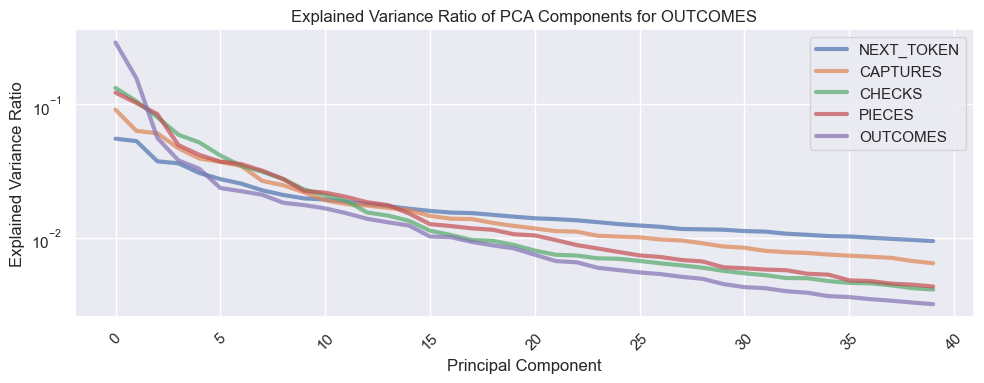

In [16]:
#Plot the explained variance ratio
plt.figure(figsize=(10, 4))

for i, (name, pca) in enumerate(pcas.items()):
    plt.semilogy(range(40), pca.explained_variance_ratio_[:40], label=name, alpha=0.7, linewidth=3)

plt.title(f'Explained Variance Ratio of PCA Components for {name}')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

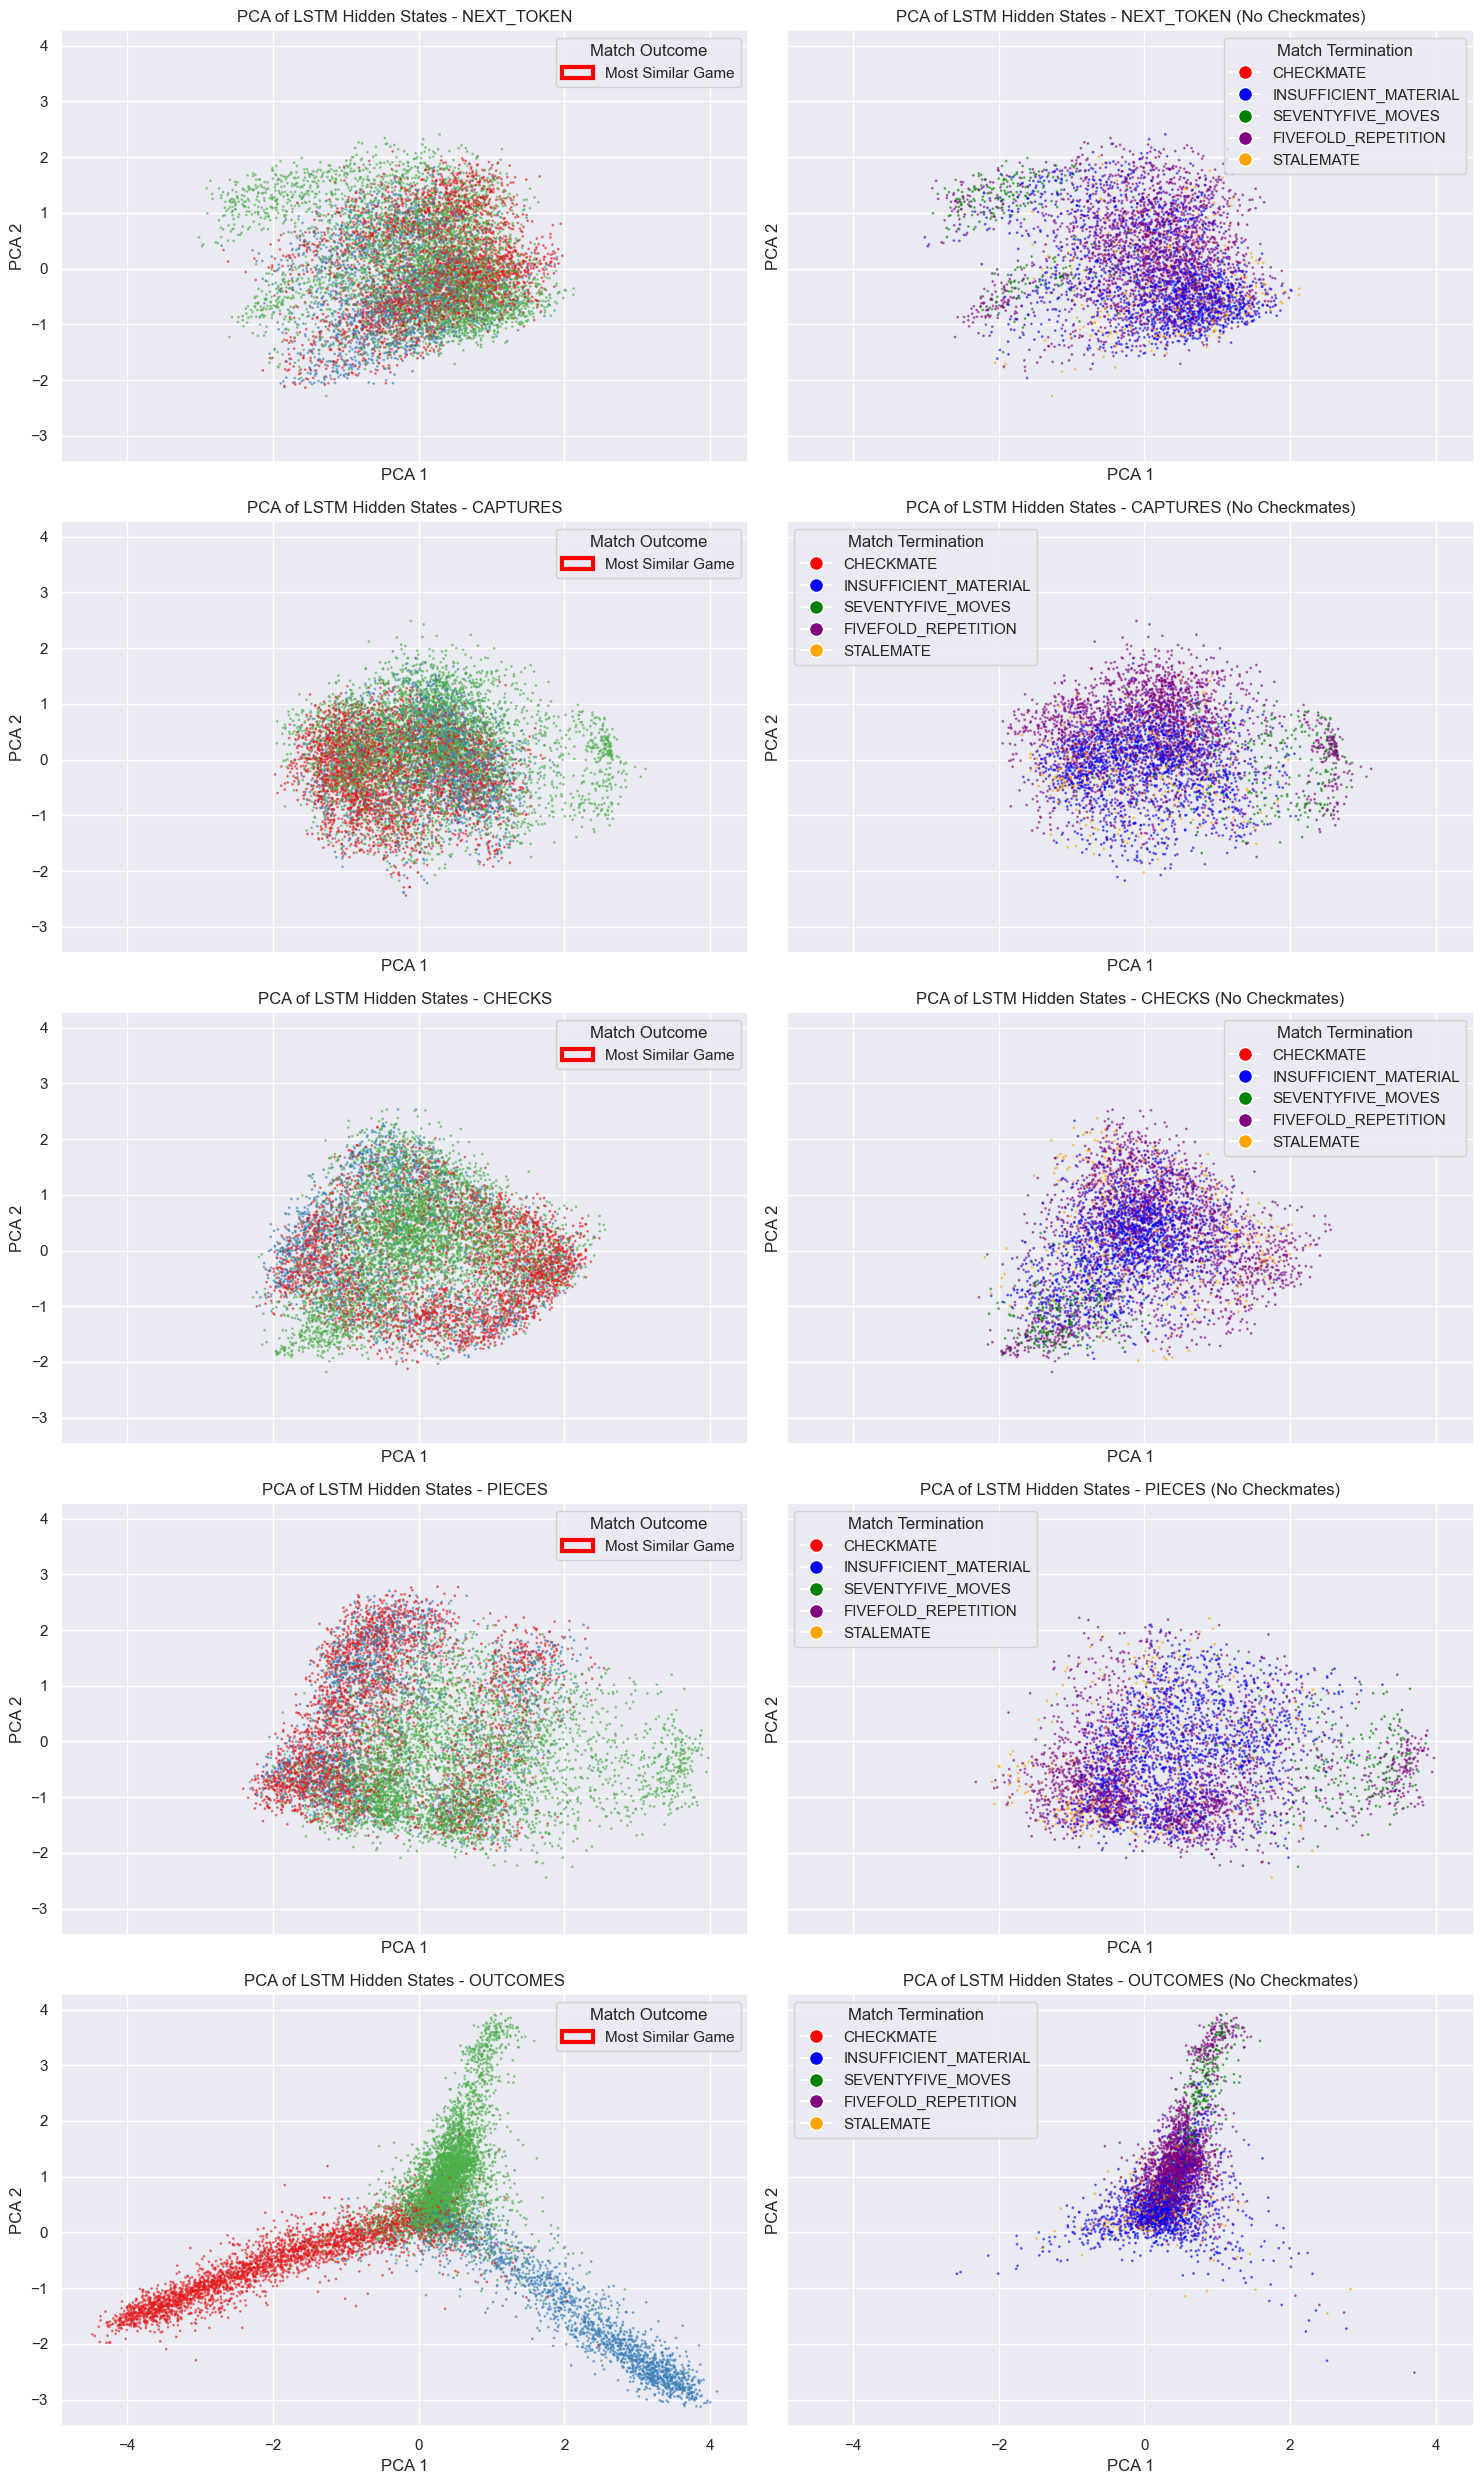

In [27]:
# Plot the PCA
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)), sharex=True, sharey=True)
for i, (name, model) in enumerate(models.items()):
    embeddingsPCA = np.array(embeddingsDf[name + '_pca'])
    embeddingsPCA = [np.array(emb) for emb in embeddingsPCA if isinstance(emb, np.ndarray) and emb.shape == (128,)]
    embeddingsPCA = np.array(embeddingsPCA)
    axes[i, 0].set_title(f"PCA of LSTM Hidden States - {name}")
    axes[i, 0].scatter(embeddingsPCA[:, 0], embeddingsPCA[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
    axes[i, 0].set_xlabel("PCA 1")
    axes[i, 0].set_ylabel("PCA 2")
    axes[i, 0].legend(handles=legend_elements, title="Match Outcome")

    axes[i, 1].set_title(f"PCA of LSTM Hidden States - {name} (No Checkmates)")
    embeddingsPCA_noCheckmates = np.array(embeddingsPCA)[matchTerminations != 'CHECKMATE']
    matchTerminationColors_noCheckmates = np.array(matchTerminationColors)[matchTerminations != 'CHECKMATE']
    axes[i, 1].scatter(embeddingsPCA_noCheckmates[:, 0], embeddingsPCA_noCheckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
    axes[i, 1].set_xlabel("PCA 1")
    axes[i, 1].set_ylabel("PCA 2")
    axes[i, 1].legend(handles=legendElementTermination, title="Match Termination")
plt.tight_layout()
plt.show()

In [18]:
np.array(embeddingsDf[name]).shape

(10000,)

In [19]:
#Perform tsne
from sklearn.manifold import TSNE

for name, model in models.items():
    print(f"[{name} - Computing TSNE...]")
    tsne = TSNE(n_components=2, perplexity=30, n_jobs=8, verbose=1, metric="cosine")
    embeddingsArray = np.array(embeddingsDf[name].tolist())
    embeddingsArray = [arr for arr in embeddingsArray if isinstance(arr, np.ndarray) and arr.shape == (128,)]
    embeddingsArray = np.array(embeddingsArray)
    cs_sampled_tsne = tsne.fit_transform(embeddingsArray)
    embeddingsDf[name + '_tsne'] = [arr for arr in cs_sampled_tsne]
    print(f"[{name} - TSNE done]")

[NEXT_TOKEN - Computing TSNE...]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 3.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.110455
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.823875
[t-SNE] KL divergence after 1000 iterations: 2

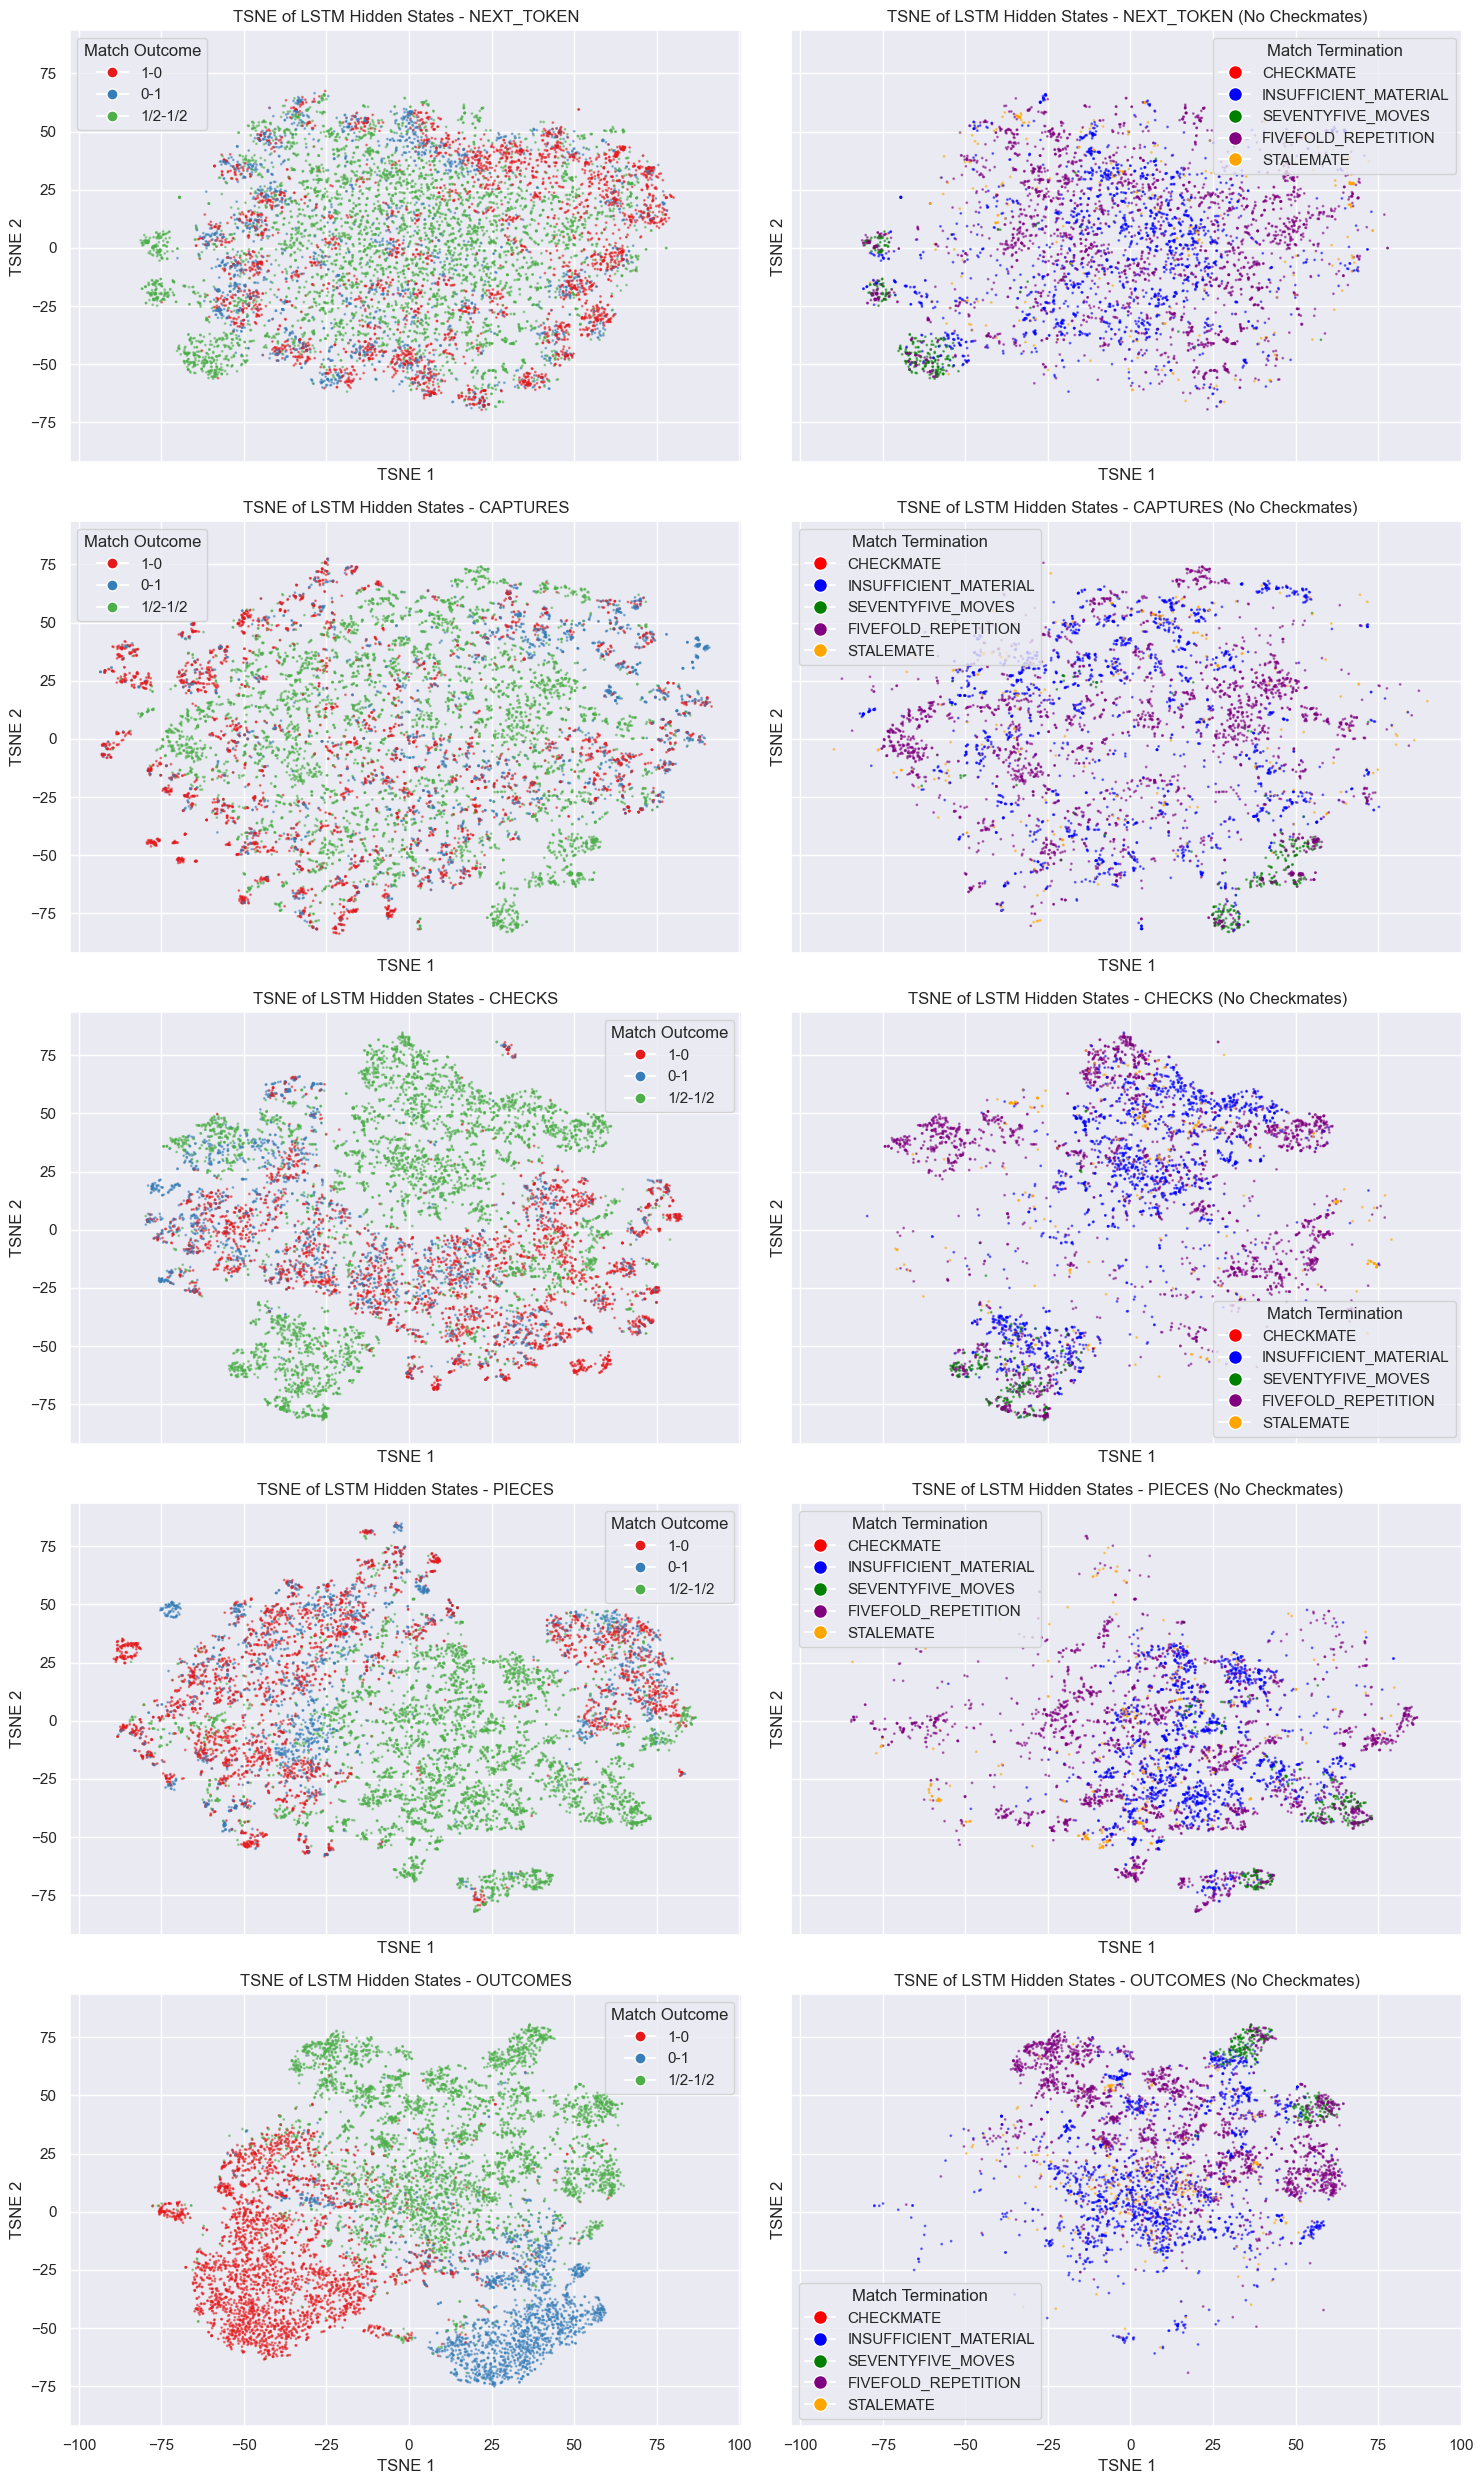

In [20]:
# Plot the t-SNE
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)), sharex=True, sharey=True)
for i, (name, model) in enumerate(models.items()):
    embeddingsTSNE = np.array(embeddingsDf[name + '_tsne'])
    embeddingsTSNE = [np.array(emb) for emb in embeddingsTSNE]
    embeddingsTSNE = np.array(embeddingsTSNE)
    axes[i, 0].set_title(f"TSNE of LSTM Hidden States - {name}")
    axes[i, 0].scatter(embeddingsTSNE[:, 0], embeddingsTSNE[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
    axes[i, 0].set_xlabel("TSNE 1")
    axes[i, 0].set_ylabel("TSNE 2")
    axes[i, 0].legend(handles=legend_elements, title="Match Outcome")

    axes[i, 1].set_title(f"TSNE of LSTM Hidden States - {name} (No Checkmates)")
    embeddingsTSNE_noCheckmates = np.array(embeddingsTSNE)[matchTerminations != 'CHECKMATE']
    matchTerminationColors_noCheckmates = np.array(matchTerminationColors)[matchTerminations != 'CHECKMATE']
    axes[i, 1].scatter(embeddingsTSNE_noCheckmates[:, 0], embeddingsTSNE_noCheckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
    axes[i, 1].set_xlabel("TSNE 1")
    axes[i, 1].set_ylabel("TSNE 2")
    axes[i, 1].legend(handles=legendElementTermination, title="Match Termination")
plt.tight_layout()
plt.show()

In [21]:
#Perform umap
import umap

for name, model in models.items():
    print(f"[{name} - Computing UMAP...]")
    umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', verbose=1)
    embeddingsArray = np.array(embeddingsDf[name].tolist())
    embeddingsArray = [arr for arr in embeddingsArray if isinstance(arr, np.ndarray) and arr.shape == (128,)]
    embeddingsArray = np.array(embeddingsArray)
    cs_sampled_tsne = umap_model.fit_transform(embeddingsArray)
    embeddingsDf[name + '_umap'] = [arr for arr in cs_sampled_tsne]
    print(f"[{name} - UMAP done]")

[NEXT_TOKEN - Computing UMAP...]
UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 18:20:20 2025 Construct fuzzy simplicial set
Sun May 25 18:20:20 2025 Finding Nearest Neighbors
Sun May 25 18:20:20 2025 Building RP forest with 10 trees


c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sun May 25 18:20:27 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Sun May 25 18:20:39 2025 Finished Nearest Neighbor Search
Sun May 25 18:20:42 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 18:20:48 2025 Finished embedding
[NEXT_TOKEN - UMAP done]
[CAPTURES - Computing UMAP...]
UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 18:20:48 2025 Construct fuzzy simplicial set
Sun May 25 18:20:48 2025 Finding Nearest Neighbors
Sun May 25 18:20:48 2025 Building RP forest with 10 trees
Sun May 25 18:20:48 2025 NN descent for 13 iterations
	 1  /  13


c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Sun May 25 18:20:48 2025 Finished Nearest Neighbor Search
Sun May 25 18:20:48 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 18:20:52 2025 Finished embedding
[CAPTURES - UMAP done]
[CHECKS - Computing UMAP...]
UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 18:20:52 2025 Construct fuzzy simplicial set
Sun May 25 18:20:52 2025 Finding Nearest Neighbors
Sun May 25 18:20:52 2025 Building RP forest with 10 trees
Sun May 25 18:20:52 2025 NN descent for 13 iterations
	 1  /  13


c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sun May 25 18:20:52 2025 Finished Nearest Neighbor Search
Sun May 25 18:20:53 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 18:20:56 2025 Finished embedding
[CHECKS - UMAP done]
[PIECES - Computing UMAP...]
UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 18:20:57 2025 Construct fuzzy simplicial set
Sun May 25 18:20:57 2025 Finding Nearest Neighbors
Sun May 25 18:20:57 2025 Building RP forest with 10 trees
Sun May 25 18:20:57 2025 NN descent for 13 iterations
	 1  /  13


c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sun May 25 18:20:57 2025 Finished Nearest Neighbor Search
Sun May 25 18:20:57 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 18:21:01 2025 Finished embedding
[PIECES - UMAP done]
[OUTCOMES - Computing UMAP...]
UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 18:21:01 2025 Construct fuzzy simplicial set
Sun May 25 18:21:01 2025 Finding Nearest Neighbors
Sun May 25 18:21:01 2025 Building RP forest with 10 trees
Sun May 25 18:21:01 2025 NN descent for 13 iterations
	 1  /  13


c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sun May 25 18:21:01 2025 Finished Nearest Neighbor Search
Sun May 25 18:21:01 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 18:21:05 2025 Finished embedding
[OUTCOMES - UMAP done]


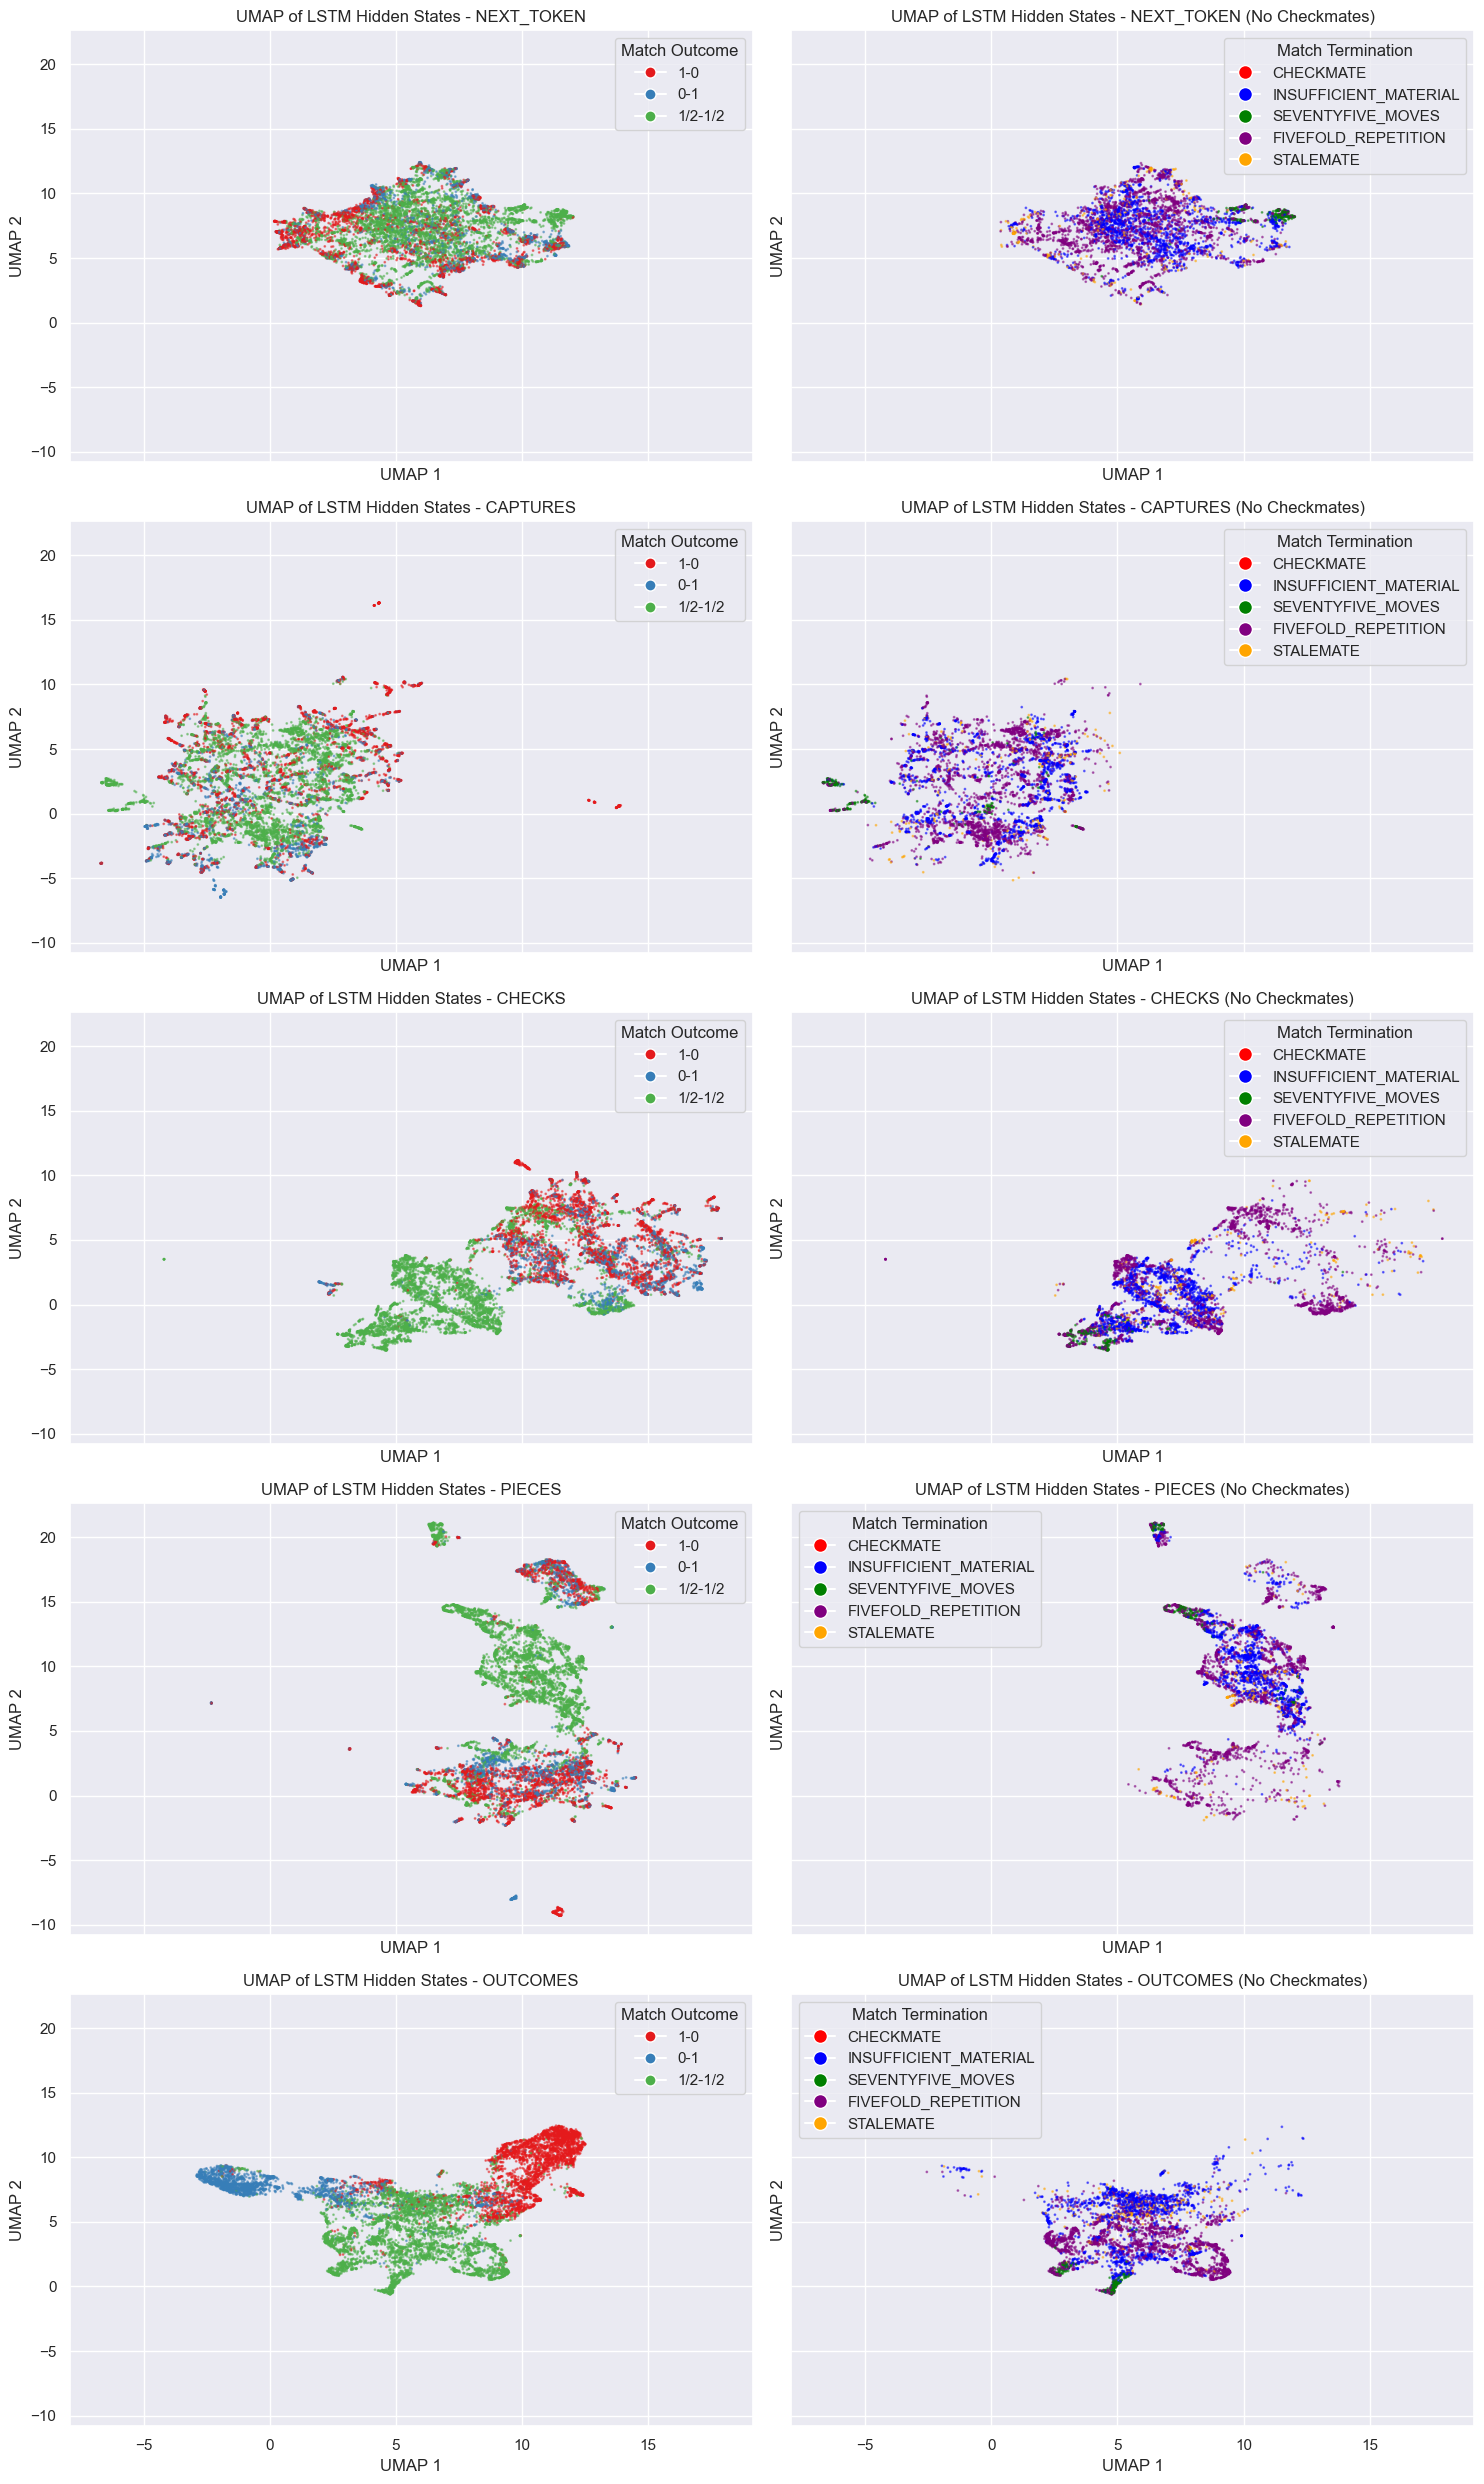

In [22]:
# Plot the UMAP
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)), sharex=True, sharey=True)
for i, (name, model) in enumerate(models.items()):
    embeddingsUMAP = np.array(embeddingsDf[name + '_umap'])
    embeddingsUMAP = [np.array(emb) for emb in embeddingsUMAP]
    embeddingsUMAP = np.array(embeddingsUMAP)
    axes[i, 0].set_title(f"UMAP of LSTM Hidden States - {name}")
    axes[i, 0].scatter(embeddingsUMAP[:, 0], embeddingsUMAP[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
    axes[i, 0].set_xlabel("UMAP 1")
    axes[i, 0].set_ylabel("UMAP 2")
    axes[i, 0].legend(handles=legend_elements, title="Match Outcome")

    axes[i, 1].set_title(f"UMAP of LSTM Hidden States - {name} (No Checkmates)")
    embeddingsUMAP_noCheckmates = np.array(embeddingsUMAP)[matchTerminations != 'CHECKMATE']
    matchTerminationColors_noCheckmates = np.array(matchTerminationColors)[matchTerminations != 'CHECKMATE']
    axes[i, 1].scatter(embeddingsUMAP_noCheckmates[:, 0], embeddingsUMAP_noCheckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
    axes[i, 1].set_xlabel("UMAP 1")
    axes[i, 1].set_ylabel("UMAP 2")
    axes[i, 1].legend(handles=legendElementTermination, title="Match Termination")
plt.tight_layout()
plt.show()


# RAG

In [23]:
def topClosestTo(game, lstmEmbeddings, n=10):
    """
    Find the top n closest games to the given game based on the UMAP embedding.
    """

    # Get the model output
    with torch.no_grad():
        lstmOutput, (h, c) = model.lstm(embeddings.unsqueeze(0))  # Add batch dimension

    # Get the last hidden state
    lastHiddenState = lstmOutput[:, -1, :].squeeze(0)

    # Compute distances in parallel using torch
    # Normalize embeddings for cosine distance
    lastHiddenState_norm = lastHiddenState / lastHiddenState.norm(dim=0, keepdim=True)
    lstmEmbeddings_norm = lstmEmbeddings / lstmEmbeddings.norm(dim=1, keepdim=True)
    similarity = torch.matmul(lstmEmbeddings_norm, lastHiddenState_norm)
    closest_indices = torch.topk(similarity, n).indices.cpu().numpy()
    return closest_indices, similarity[closest_indices].cpu().numpy()

for name, model in models.items():
    print(f"[{name} - Finding top closest games...]")
    lstmEmbeddings = embeddingsDf[name].tolist()
    lstmEmbeddings = [np.array(emb) for emb in lstmEmbeddings]
    lstmEmbeddings = np.array(lstmEmbeddings)
    lstmEmbeddings = torch.Tensor(lstmEmbeddings)
    # Example game to find closest matches
    example_game = moves.iloc[1]
    example_game = getW2VEmbeddings(example_game)
    closest_indices, similarities = topClosestTo(example_game, lstmEmbeddings, n=10)
    
    print(f"Top 10 closest games for {name}:")
    for idx, sim in zip(closest_indices, similarities):
        print(f"Index: {idx}, Similarity: {sim.item()}")

[NEXT_TOKEN - Finding top closest games...]
Top 10 closest games for NEXT_TOKEN:
Index: 9999, Similarity: 0.9999998807907104
Index: 8058, Similarity: 0.786525309085846
Index: 3893, Similarity: 0.7847261428833008
Index: 4627, Similarity: 0.7524425983428955
Index: 825, Similarity: 0.7512696385383606
Index: 8802, Similarity: 0.7194738388061523
Index: 8957, Similarity: 0.7117308974266052
Index: 4200, Similarity: 0.701873779296875
Index: 8419, Similarity: 0.6964709758758545
Index: 3122, Similarity: 0.6961824893951416
[CAPTURES - Finding top closest games...]
Top 10 closest games for CAPTURES:
Index: 9999, Similarity: 1.0000001192092896
Index: 4627, Similarity: 0.9466715455055237
Index: 5730, Similarity: 0.8892415761947632
Index: 280, Similarity: 0.8716875910758972
Index: 8058, Similarity: 0.8710367679595947
Index: 8957, Similarity: 0.8704618215560913
Index: 9559, Similarity: 0.8612872362136841
Index: 6338, Similarity: 0.841956377029419
Index: 102, Similarity: 0.8345199227333069
Index: 3893,

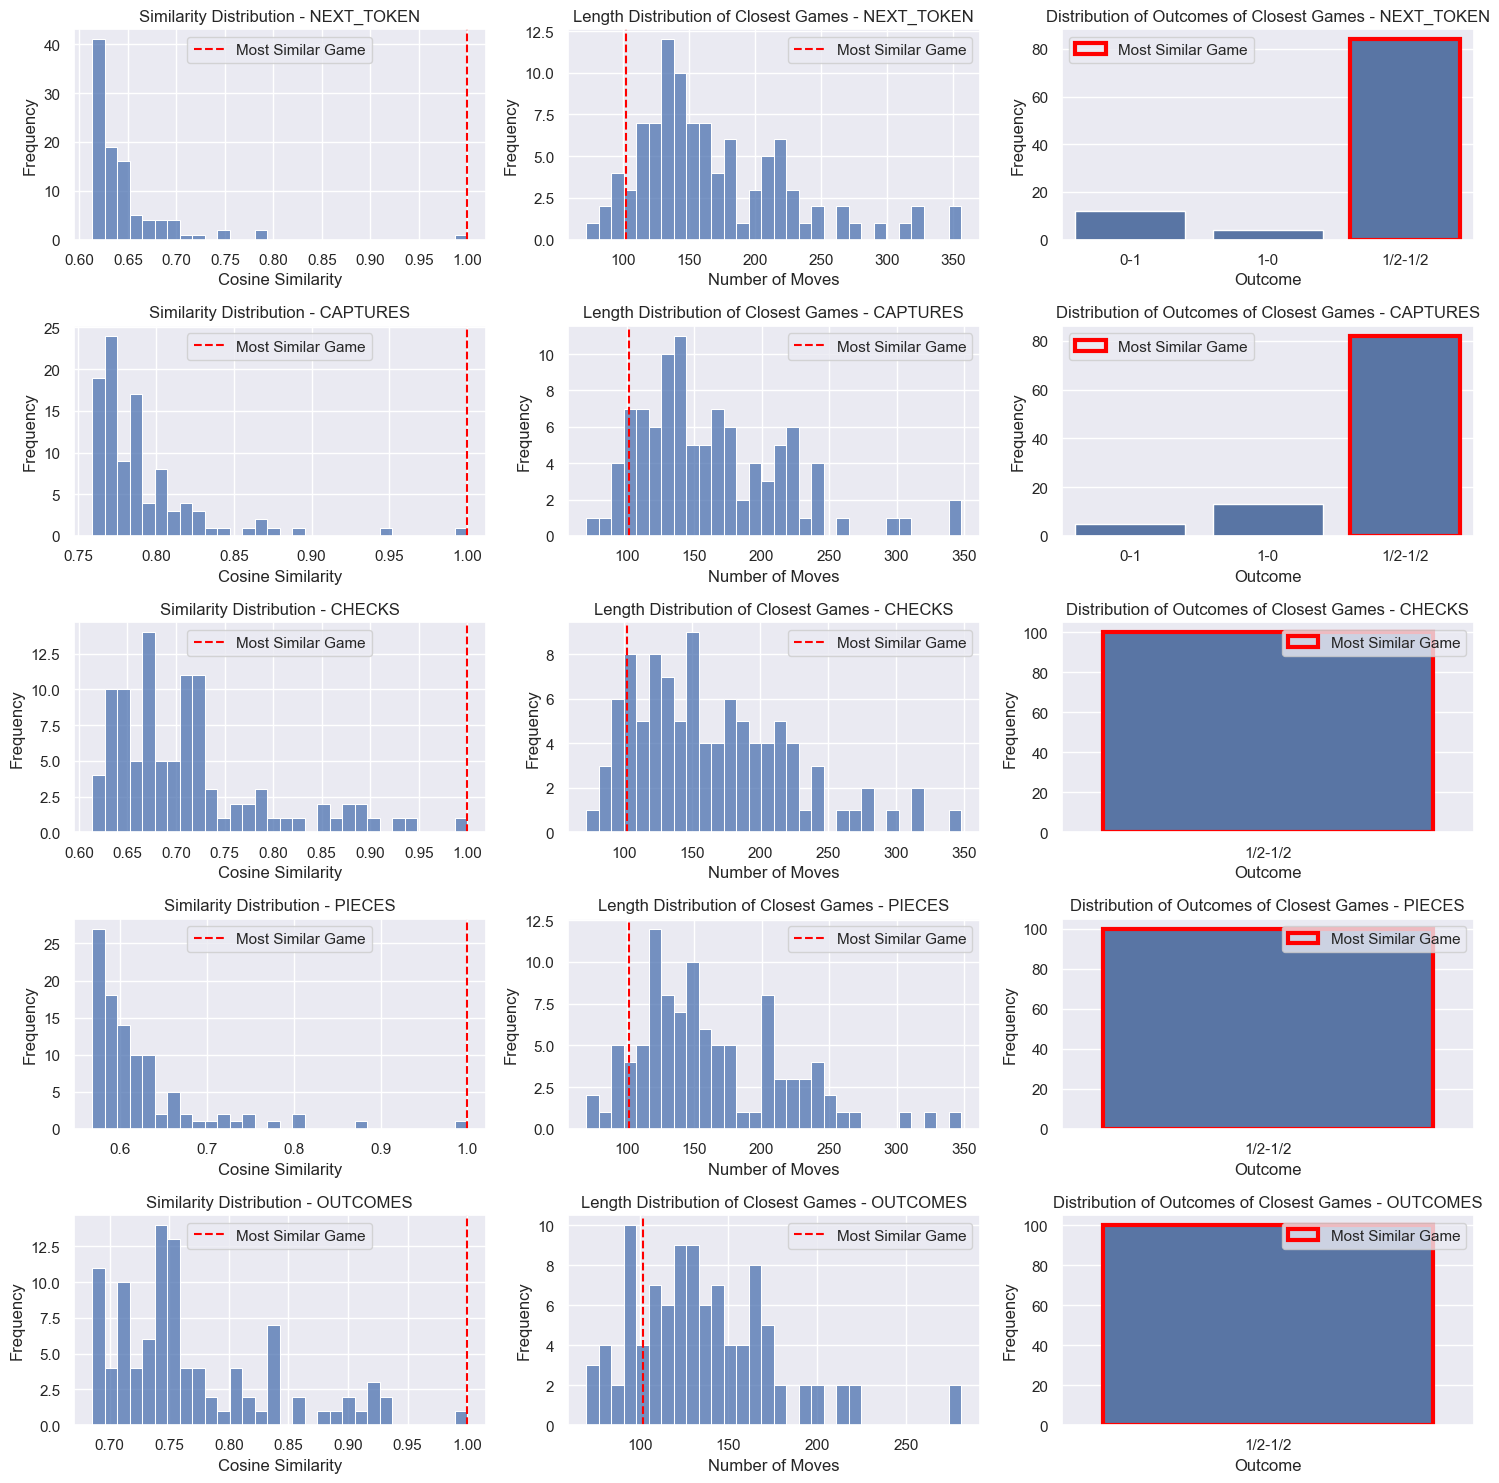

In [24]:
from matplotlib.patches import Patch

# Example game to find closest matches
example_game = moves.iloc[3]
example_game = getW2VEmbeddings(example_game)
n = 100

fig, axes = plt.subplots(len(models), 3, figsize=(15, 3 * len(models)))
for i, (name, model) in enumerate(models.items()):
    lstmEmbeddings = embeddingsDf[name].tolist()
    lstmEmbeddings = [np.array(emb) for emb in lstmEmbeddings]
    lstmEmbeddings = np.array(lstmEmbeddings)
    lstmEmbeddings = torch.Tensor(lstmEmbeddings)

    closest_indices, similarities = topClosestTo(example_game, lstmEmbeddings, n=n)

    #Plot the similarity distribution using sns
    sns.histplot(similarities, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Similarity Distribution - {name}")
    axes[i, 0].set_xlabel("Cosine Similarity")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].axvline(similarities[0], color='red', linestyle='--', label='Most Similar Game')
    axes[i, 0].legend()

    # Plot the lengths of the closest games
    closest_games = [moves.iloc[idx] for idx in closest_indices]
    lengths = [len(game) for game in closest_games]
    sns.histplot(lengths, bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f"Length Distribution of Closest Games - {name}")
    axes[i, 1].set_xlabel("Number of Moves")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].axvline(lengths[0], color='red', linestyle='--', label='Most Similar Game')
    axes[i, 1].legend()

    # Plot the outcomes of the closest games
    closest_outcomes = matchOutcomes[closest_indices]
    sns.countplot(x=closest_outcomes, ax=axes[i, 2], order=np.unique(closest_outcomes))
    axes[i, 2].set_title(f"Distribution of Outcomes of Closest Games - {name}")
    axes[i, 2].set_xlabel("Outcome")
    axes[i, 2].set_ylabel("Frequency")
    #Mark the outcome of the most similar game
    most_similar_outcome = closest_outcomes[0]
    unique_outcomes = np.unique(closest_outcomes)
    most_similar_idx = np.where(unique_outcomes == most_similar_outcome)[0][0]
    for j, p in enumerate(axes[i, 2].patches):
        if j == most_similar_idx:
            p.set_edgecolor('red')
            p.set_linewidth(3)
    # Add legend for the most similar game
    legend_elements = [Patch(facecolor='none', edgecolor='red', linewidth=3, label='Most Similar Game')]
    axes[i, 2].legend(handles=legend_elements)
plt.tight_layout()
plt.show()